In [2]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:
class Env():

    def __init__(self):
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.actions = ["RIGHT", "DOWN", "LEFT", "UP"]
        self.max_x = 9
        self.max_y = 6
        self.start = [0, 3]
        self.goal = [7, 3]
        self.current = self.start

    def step(self, action):

        self.current[1] += self.wind[self.current[0]]

        if action == "LEFT":
            self.current[0] -= 1
        elif action == "RIGHT":
            self.current[0] += 1
        elif action == "UP":
            self.current[1] += 1
        elif action == "DOWN":
            self.current[1] -= 1
        else:
            raise ValueError("Invalid action")
        
        if self.current[0] < 0:
            self.current[0] = 0
        elif self.current[0] > self.max_x:
            self.current[0] = self.max_x
    
        if self.current[1] < 0:
            self.current[1] = 0
        elif self.current[1] > self.max_y:
            self.current[1] = self.max_y

        if self.current == self.goal:
            return self.current, 0, True
        else:
            return self.current, -1, False
        
    def reset(self, state = None):
        if state is not None:
            self.current = state
        else:
            self.current = self.start
        return self.current
    
    def render(self):
        for y in range(self.max_y, -1, -1):
            for x in range(self.max_x + 1):
                if [x, y] == self.current:
                    print("X", end = " ")
                elif [x, y] == self.start:
                    print("S", end = " ")
                elif [x, y] == self.goal:
                    print("G", end = " ")
                else:
                    print(".", end = " ")
            print()
        for x in range(self.max_x + 1):
            print(self.wind[x], end = " ")
        print()

In [4]:
# e = Env()
# while True:
#     e.render()
#     action = input("action: ")
#     next_state, reward, done = e.step(action)
#     if done:
#         break
# e.render()


In [26]:
class Agent():
    """
    epsilon-greedy Sarsa to
    this task, with epsilon=0.1, alpha=0.5,
    and the initial values Q(s,a)=0
    for all s,a.
    """
    
    def __init__(self, env):
        self.env = env
        self.init_Q()
        self.gamma = .99

    def init_Q(self):
        self.Q = {}
        for action in self.env.actions:
            for x in range(self.env.max_x + 1):
                for y in range(self.env.max_y + 1):
                    self.Q[(x, y, action)] = .5
            self.Q[(self.env.goal[0], self.env.goal[1], action)] = 0
    
    def epsilon_greedy_policy(self, state, epsilon):
        # if it is a tie, random choice
        if random.random() < epsilon:
            return random.choice(self.env.actions)
        elif self.Q[(state[0], state[1], "LEFT")] == self.Q[(state[0], state[1], "RIGHT")] == self.Q[(state[0], state[1], "UP")] == self.Q[(state[0], state[1], "DOWN")]:
                return random.choice(self.env.actions)
        return max(self.env.actions, key = lambda action: self.Q[(state[0], state[1], action)])
        
    def sarsa(self, num_episodes = 170, alpha = 0.5, epsilon = 0.9):
        time_steps = []
        ts = 0
        episodes = []
        for episode in tqdm.tqdm(range(num_episodes), desc = "Training"):
            episodes.append(episode)
            time_steps.append(ts)
            epsilon /= 1.1
            state = self.env.reset()
            while state != self.env.goal:
                action = self.epsilon_greedy_policy(state, epsilon)
                next_state, reward, done = self.env.step(action)
                next_action = self.epsilon_greedy_policy(next_state, epsilon)
                self.Q[(state[0], state[1], action)] += alpha * (reward + self.gamma * self.Q[(next_state[0], next_state[1], next_action)] - self.Q[(state[0], state[1], action)])
                state = next_state
                action = next_action
                ts += 1

        return episodes, time_steps    

    def train(self, num_episodes = 170):
        episodes, time_steps = self.sarsa(num_episodes)
        self.disp()
        
        # plot
        sns.lineplot(x = time_steps, y = episodes)
        plt.xlabel("Time Steps")
        plt.ylabel("Episodes")
        plt.title("Sarsa")
        plt.show()
    
    def play(self):
        state = self.env.reset()
        _return = 0
        while state != self.env.goal:
            action = max(self.env.actions, key = lambda action: self.Q[(state[0], state[1], action)])
            state, r, _ = self.env.step(action)
            _return += r
            self.env.render()
        print(f"\nReturn: {_return}")    

    def disp(self):
        """display the agent's policy with unicode arrows"""
        for y in range(self.env.max_y, -1, -1):
            for x in range(self.env.max_x + 1):
                if [x, y] == self.env.goal:
                    print("G", end = " ")
                else:
                    # if there's a tie, show all actions
                    if self.Q[(x, y, "LEFT")] == self.Q[(x, y, "RIGHT")] == self.Q[(x, y, "UP")] == self.Q[(x, y, "DOWN")]:
                        print("?", end = " ")
                    else:
                        action = max(self.env.actions, key = lambda action: self.Q[(x, y, action)])
                        if action == "LEFT":
                            print("←", end = " ")
                        elif action == "RIGHT":
                            print("→", end = " ")
                        elif action == "UP":
                            print("↑", end = " ")
                        elif action == "DOWN":
                            print("↓", end = " ") 
            print()  
        print() 

Training: 100%|██████████| 170/170 [00:01<00:00, 110.83it/s]


→ ↓ ↓ → → ↓ ← → ↑ ↓ 
→ ← ← ← ← ← ↓ → → ← 
→ ↑ ↑ ↑ ↑ ↓ ↓ → → ← 
→ ← ← ← ← ← ? G → ← 
→ ↑ ↑ ← ← ? ? → → ← 
→ ↑ ← ← ← ? ? ? → ← 
→ ↑ ← ← ? ? ? ? ? ? 



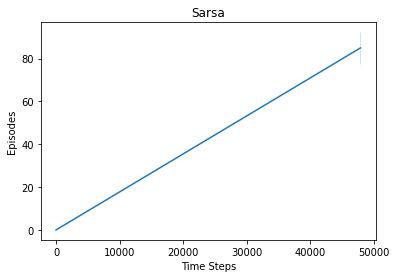

In [27]:
env = Env()
agent = Agent(env)
agent.train()


In [ ]:
agent.play()


Return: 0
